<a href="https://www.kaggle.com/code/bhavinmoriya/markowitz-portfolio-optimization?scriptVersionId=112870591" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Any investor does not want to take risk and want to make max profit possible. Speaking of which, we have to say there is a tradeoff between those quantities. Research says one should not see risk and return as separate things. More risk you carry, more profit you should expect and much more you can make will be answers by Markowitz portfolio optimization (MPO).

- Given the portfolio (MPO) assign weights of each security
- it weights in a way that we get max profit with given amount of risk (everyone has different appetite for risk).

We shall try to assign weights to securities (Tesla, Google, Meta, Microsoft) to optimize the return based on the given risk. All this will be done using Markowitz Portfolio Optimization, aka Modern Port. Theory, invented by Harry Markowitz. We shall do all this using two approaches,

1. Monte Carlo simulation
2. Finding out minimal -- Using SciPy 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td

# plt.rc\\\

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
end = dt.today()
start = end - td(days=2000)
stocks = 'AMZN TSLA META MSFT'.split()
df = web.get_data_yahoo(stocks, start, end)

In [3]:
# remove multilevel
df.columns = ['_'.join(col) for col in df.columns]

# Just study adj close 
df = df.iloc[:,:4]

In [4]:
df

,Adj Close_AMZN,Adj Close_TSLA,Adj Close_META,Adj Close_MSFT
Date,,,,
2017-06-13,49.039501,25.063334,150.679993,65.848854
2017-06-14,48.823502,25.377333,150.250000,65.494667
2017-06-15,48.208500,25.022667,149.800003,65.149826
2017-06-16,49.385502,24.760000,150.639999,65.243019
2017-06-19,49.758499,24.653334,152.869995,66.053917
...,...,...,...,...
2022-11-28,93.949997,182.919998,108.779999,241.759995
2022-11-29,92.419998,180.830002,109.459999,240.330002
2022-11-30,96.540001,194.699997,118.099998,255.139999


In [5]:
px.line(df * 100 / df.iloc[0])

In [6]:
ret_port = df.pct_change()
px.line(ret_port)

Looks like TSLA is having a jumpy ride, as you might have thought :)

In [7]:
np.random.seed(1)
# Weight each security
weights = np.random.random((4,1))
# normalize it, so that some is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(df / df.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.89640161e-01 5.00297106e-01 7.94383512e-05 2.09983296e-01]

Expected return of the portfolio is : 0.2739662948573788

Volatility of the portfolio: 0.4087400812756175

Sharpe ratio of the portfolio: 0.6702701971442839


# Monte Carlo Simulation

We basically randomly initialize weights of the securities and check the returns vs risks. And among these set of weights we will find the one, for given risk, which gives the maximum return. However, one can do all this solving optimization problem, using SciPy. 

In [8]:
# number of simulation
n = 50_000
# n = 10

port_weights = np.zeros(shape=(n,len(df.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(df.columns)
# num_securities
for i in range(n):
    # Weight each security
    weights = np.random.random(4)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret / exp_vol
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [9]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]


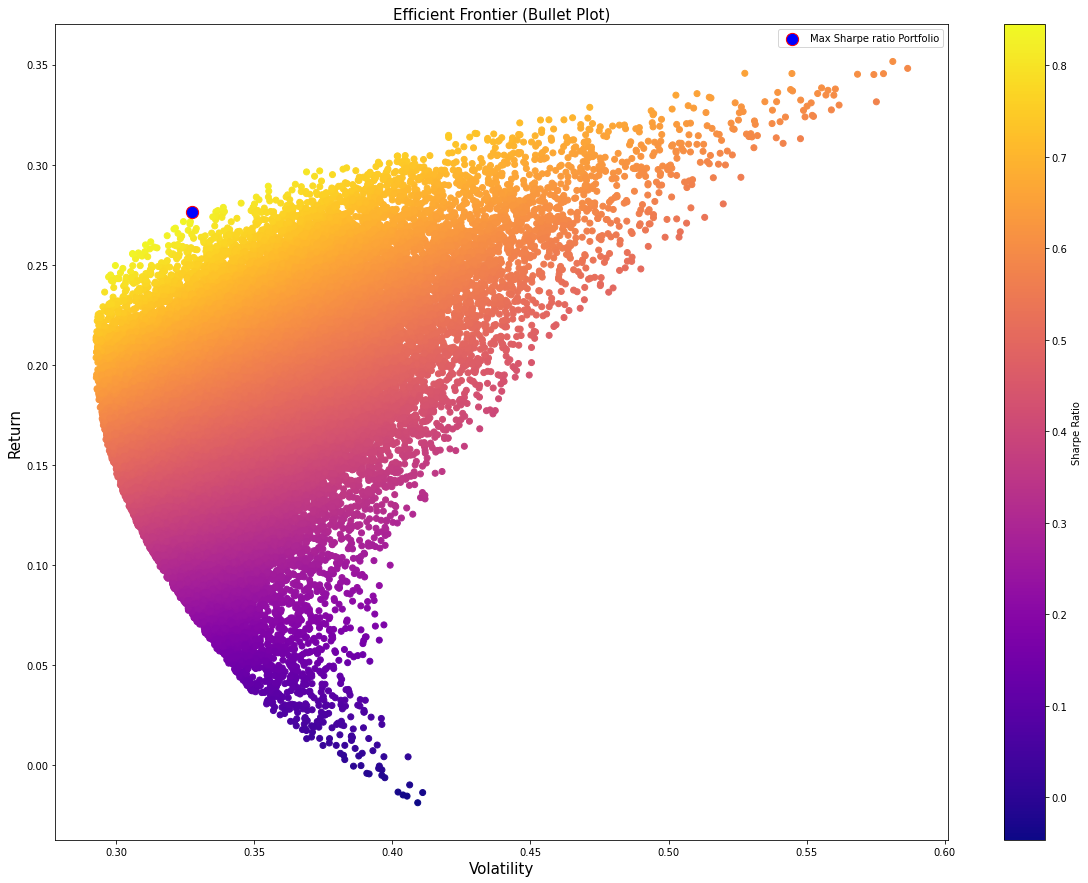

In [10]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

In [11]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')
    
# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

1.31 % of AMZN should be bought.
24.84 % of TSLA should be bought.
0.29 % of META should be bought.
73.56 % of MSFT should be bought.

Markowitz optimal portfolio return is : 27.66% with volatility 0.32739967505425815


All we did above can be done using optimization, which we do next.

# SciPy to get the max of Sharpe Ration

In [12]:
from scipy import optimize

In [13]:
log_mean = log_ret.mean() * 252
cov = log_ret.cov() * 252

In [14]:
# Some helper functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = log_mean.dot(weights)
    vol = np.sqrt(weights.T.dot(cov.dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

# Negate Sharpe ratio as we need to max it but Scipy minimize the given function
def neg_sr(weights):
    return get_ret_vol_sr(weights)[-1] * -1

# check sum of weights 
def check_sum(weights):
    return np.sum(weights) - 1

# Constraints for the optimization problem
cons = {'type':'eq','fun':check_sum}
# bounds on weights
bounds = ((0,1),(0,1),(0,1),(0,1))
# initial guess for optimization to start with
init_guess = [.25 for _ in range(4)]


# Call minimizer
opt_results = optimize.minimize(neg_sr, init_guess, constraints=cons, bounds=bounds, method='SLSQP')


In [15]:
optimal_weights = opt_results.x
# optimal_weights
for st, i in zip(stocks,optimal_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')

Stock AMZN has weight 0.0 %
Stock TSLA has weight 15.66 %
Stock META has weight 0.0 %
Stock MSFT has weight 84.34 %


In [16]:
mc_weights = port_weights[ind]
for st, i in zip(stocks,mc_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')

Stock AMZN has weight 1.31 %
Stock TSLA has weight 24.84 %
Stock META has weight 0.29 %
Stock MSFT has weight 73.56 %


In [17]:
# Comparing two results we see that we get very close results
(optimal_weights - mc_weights)

array([-0.01309669, -0.091764  , -0.00286768,  0.10772837])

In [18]:
get_ret_vol_sr(optimal_weights), get_ret_vol_sr(mc_weights)

print('For a given portfolio we have: (Using SciPy optimizer)\n \n')
for i, j in enumerate('Return Volatility SharpeRatio'.split()):
    print(f'{j} is : {get_ret_vol_sr(optimal_weights)[i]}\n')
    
print('For a given portfolio we have: (Using Monte Carlo)\n \n')
for i, j in enumerate('Return Volatility SharpeRatio'.split()):
    print(f'{j} is : {get_ret_vol_sr(mc_weights)[i]}\n')

For a given portfolio we have: (Using SciPy optimizer)
 

Return is : 0.2673743722382096

Volatility is : 0.3105588012906701

SharpeRatio is : 0.8609460466971546

For a given portfolio we have: (Using Monte Carlo)
 

Return is : 0.27656689122755684

Volatility is : 0.32739967505425815

SharpeRatio is : 0.8447378305483135



So MC and Optimizer gives very close results. MC is good, but if we have many assets, since MC computationally heavy, SciPy is going to be a saviour!!!

# Frontier curve

Best return for given volatility or vice versa.

In [19]:
frontier_y = np.linspace(port_return.min(), port_return.max(), 100)
frontier_vol = []

def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

for possible_ret in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0] - possible_ret})
    result = optimize.minimize(minimize_vol, init_guess, method='SLSQP', constraints=cons, bounds=bounds)
    frontier_vol.append(result['fun'])    

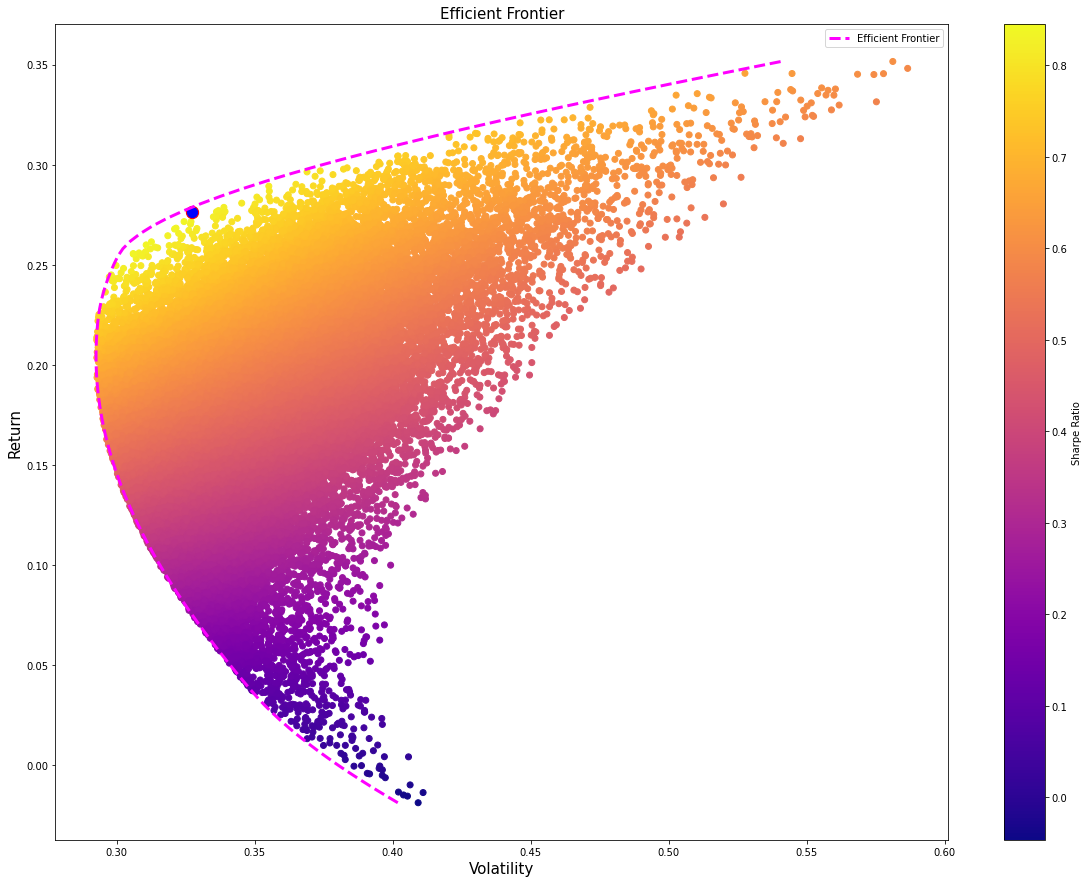

In [20]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o')

plt.plot(frontier_vol, frontier_y, c='magenta', ls='--', lw=3, label='Efficient Frontier')
plt.legend();

It is common practice to choose the portfolio with max sharpe ratio. Thought one can always make a choice as per one's taste. Efficient frontier gives us max profit for given amount of risk. So anything below the given efficient frontier will be a bad choice (of course, we are assuming above the risk free rate).

CAPM, Beta and Sharpe ratio are tools to evaluate the stocks too. One may see,
https://www.kaggle.com/code/bhavinmoriya/beta-of-a-stock-capm-from-scratch